# GIS project (Geo 885)
*Authors: Alessandro Joshua Pierro 20-733-861, Fabio Schilling 19-704-048*     
*Date: 10.06.2024* 

## Topic 1: spatial accessibility

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [2]:
# Define the Swiss CRS
crs_sui = 2056

# Read the ZüriACT data in & convert it to the Swiss CRS
zuriact = gpd.read_file('data/züriact_data.json')
zuriact = zuriact.to_crs(crs_sui)

In [3]:
# Drop all unecessary columns
zuriact = zuriact.drop(columns=['attribute_id', 'street_edge_id', 'osm_street_id', 'gsv_panorama_id', 'heading', 'pitch', 'zoom', 'canvas_x', 'canvas_y', 
                                'canvas_height', 'canvas_width', 'gsv_url', 'image_capture_date', 'label_date', 'notsure_count', 'label_description', 'user_id'])

In [4]:
# Get an overview of the data
zuriact.describe()

,severity,label_id,label_severity,agree_count,disagree_count
count,4185.000000,4917.000000,4065.000000,4917.000000,4917.000000
mean,1.851852,4522.961359,1.837146,2.323571,0.221070
std,1.118050,2587.193494,1.179320,1.152720,0.495032
min,1.000000,11.000000,1.000000,0.000000,0.000000
25%,1.000000,2111.000000,1.000000,2.000000,0.000000
50%,2.000000,4438.000000,1.000000,2.000000,0.000000
75%,2.000000,6782.000000,2.000000,3.000000,0.000000
max,5.000000,8907.000000,5.000000,8.000000,3.000000


In [5]:
# Get some more overview of data
print(zuriact)

          label_type  neighborhood  severity  is_temporary  label_id  \
0     SurfaceProblem  Grossmünster       2.0         False       284   
1     SurfaceProblem      Oberdorf       3.0         False       924   
2           CurbRamp     Stadthaus       1.0         False      1854   
3           CurbRamp     Stadthaus       1.0         False      1855   
4           CurbRamp     Stadthaus       2.0         False      1853   
...              ...           ...       ...           ...       ...   
4912          Signal     Sihlporte       NaN         False      2758   
4913          Signal     Sihlporte       NaN         False      2762   
4914          Signal     Sihlporte       NaN         False      2764   
4915          Signal     Sihlporte       NaN         False      2795   
4916        CurbRamp  Bahnhofplatz       2.0         False      8193   

      label_severity  label_is_temporary  agree_count  disagree_count  \
0                3.0               False            2         

In [6]:
# Read in the City of Zürich's geometry
zuri = gpd.read_file('data/data_züri/stzh.adm_stadtkreise_a.json')
print(zuri)

   objid bezeichnung name entstehung  \
0      1     Kreis 6    6          4   
1     10    Kreis 11   11          4   
2     11    Kreis 12   12          4   
3     12    Kreis 10   10          4   
4      2     Kreis 4    4          1   
5      3     Kreis 1    1          4   
6      4     Kreis 9    9          4   
7      5     Kreis 5    5          1   
8      6     Kreis 7    7          6   
9      7     Kreis 3    3          4   
10     8     Kreis 2    2          4   
11     9     Kreis 8    8          6   

                                             geometry  
0   POLYGON ((8.52602 47.40844, 8.52618 47.40825, ...  
1   POLYGON ((8.48438 47.42904, 8.48443 47.42899, ...  
2   POLYGON ((8.55353 47.39929, 8.55365 47.39917, ...  
3   POLYGON ((8.46802 47.41334, 8.46803 47.41332, ...  
4   POLYGON ((8.49762 47.38834, 8.49830 47.38814, ...  
5   POLYGON ((8.52922 47.36920, 8.52943 47.36903, ...  
6   POLYGON ((8.44802 47.38025, 8.44848 47.37966, ...  
7   POLYGON ((8.49837 47.39205,

In [7]:
# Filter the City dataset for Kreis 1 and drom unecessary data
kreis1 = zuri[zuri['name'] == '1']
print(kreis1)
kreis1 = kreis1.drop(columns=['objid', 'name','entstehung'])
print(kreis1)

  objid bezeichnung name entstehung  \
5     3     Kreis 1    1          4   

                                            geometry  
5  POLYGON ((8.52922 47.36920, 8.52943 47.36903, ...  
  bezeichnung                                           geometry
5     Kreis 1  POLYGON ((8.52922 47.36920, 8.52943 47.36903, ...


In [8]:
# Change to Swiss CRS
kreis1 = kreis1.to_crs(crs_sui)
print(kreis1)

  bezeichnung                                           geometry
5     Kreis 1  POLYGON ((2682373.145 1247056.986, 2682389.494...


In [9]:
# Read in public transport stops for Canton Zürich
stops = gpd.read_file('data/Haltestellen_des_offentlichen_Verkehrs_-OGD/ZVV_HALTESTELLEN_P.shp')
print(stops)

       NHSTID  DIVA_NR Y_KOORD X_KOORD                        CHSTNAME  \
0     8573270     1706    None    None                Bachs, Neu-Bachs   
1     8573267     3177    None    None              Stadel b. N., Stig   
2     8503315    10655    None    None                       Dielsdorf   
3     8503314    11734    None    None                     Niederhasli   
4     8573262       83    None    None  Niederglatt ZH,Altes Schulhaus   
...       ...      ...     ...     ...                             ...   
1638  8581548     3672    None    None              Uster, Poststrasse   
1639  8575922      965    None    None            Illnau, Gemeindehaus   
1640  8588098     3802    None    None              Gutenswil, Sternen   
1641  8503170     1553    None    None              Esslingen, Lieburg   
1642  8581542      579    None    None              Uster, Burgstrasse   

                       CNAME    VTYP  \
0                      Bachs     Bus   
1     Stadel bei Niederglatt   

In [10]:
# Drop unecessary columns
stops = stops.drop(columns = ['NHSTID', 'DIVA_NR', 'Y_KOORD', 'X_KOORD', 'HSTTYP', 'HAFAS_PRIO', 'LINKTEXT', 'ZONEN', 'SYMB_CODE', 'SYMB_TEXT'])

In [11]:
# Spatial join of Kreis 1 and public transport stops
stops_kreis1 = gpd.sjoin(stops, kreis1, op='within')
stops_kreis1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 31 entries, 65 to 1499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   CHSTNAME     31 non-null     object  
 1   CNAME        31 non-null     object  
 2   VTYP         25 non-null     object  
 3   LINIEN       25 non-null     object  
 4   geometry     31 non-null     geometry
 5   index_right  31 non-null     int64   
 6   bezeichnung  31 non-null     object  
dtypes: geometry(1), int64(1), object(5)
memory usage: 1.9+ KB


c:\Users\Fabio\anaconda3\envs\geo876\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
# Remove old stop(s)
stops_kreis1 = stops_kreis1[stops_kreis1['CHSTNAME'] != 'Zürich HB Museum']

# Set an index
stops_kreis1['STOPID'] = range(1, len(stops_kreis1) + 1)
stops_kreis1 = stops_kreis1.set_index('STOPID')
print(stops_kreis1)

                              CHSTNAME   CNAME                 VTYP  \
STOPID                                                                
1               Zürich, Bahnhof Selnau  Zürich                 Tram   
2               Zürich, Bahnhofquai/HB  Zürich      Tram,Trolleybus   
3             Zürich Bürkliplatz (See)  Zürich                 None   
4           Zürich, Rudolf-Brun-Brücke  Zürich             Bus,Tram   
5             Zürich, Central Polybahn  Zürich        Standseilbahn   
6                        Zürich HB SZU  Zürich               S-Bahn   
7                    Zürich Limmatquai  Zürich                 None   
8                     Zürich, Neumarkt  Zürich  Bus,Tram,Trolleybus   
9       Zürich, ETH/Universitätsspital  Zürich             Bus,Tram   
10               Zürich, Kantonsschule  Zürich                 Tram   
11             Zürich, Bahnhofplatz/HB  Zürich  Bus,Tram,Trolleybus   
12                     Zürich Storchen  Zürich                 None   
13    

In [13]:
# Adjust stops without VTYP (Verkehrstyp) to be Schiff (we checked, its ok)
for index, value in stops_kreis1['VTYP'].items():
    if value == None:
        stops_kreis1.at[index, 'VTYP'] = 'Schiff'

print(stops_kreis1)

                              CHSTNAME   CNAME                 VTYP  \
STOPID                                                                
1               Zürich, Bahnhof Selnau  Zürich                 Tram   
2               Zürich, Bahnhofquai/HB  Zürich      Tram,Trolleybus   
3             Zürich Bürkliplatz (See)  Zürich               Schiff   
4           Zürich, Rudolf-Brun-Brücke  Zürich             Bus,Tram   
5             Zürich, Central Polybahn  Zürich        Standseilbahn   
6                        Zürich HB SZU  Zürich               S-Bahn   
7                    Zürich Limmatquai  Zürich               Schiff   
8                     Zürich, Neumarkt  Zürich  Bus,Tram,Trolleybus   
9       Zürich, ETH/Universitätsspital  Zürich             Bus,Tram   
10               Zürich, Kantonsschule  Zürich                 Tram   
11             Zürich, Bahnhofplatz/HB  Zürich  Bus,Tram,Trolleybus   
12                     Zürich Storchen  Zürich               Schiff   
13    

In [14]:
# Show map with all public transport stops
m = folium.Map(location=[47.3769, 8.5417], zoom_start=15)
folium.GeoJson(stops_kreis1).add_to(m)
folium.GeoJson(stops_kreis1, tooltip=folium.GeoJsonTooltip(fields=['CHSTNAME', 'VTYP'])).add_to(m)
m

In [15]:
# Buffer all public transport stops by 100m
buffered_stops = stops_kreis1.buffer(100)
buffered_stops_gdf = gpd.GeoDataFrame(geometry=buffered_stops)

print(buffered_stops_gdf)

                                                 geometry
STOPID                                                   
1       POLYGON ((2682682.000 1247223.000, 2682681.518...
2       POLYGON ((2683402.000 1247991.000, 2683401.518...
3       POLYGON ((2683368.000 1246676.000, 2683367.518...
4       POLYGON ((2683501.000 1247599.000, 2683500.518...
5       POLYGON ((2683584.000 1247884.000, 2683583.518...
6       POLYGON ((2683201.000 1248002.000, 2683200.518...
7       POLYGON ((2683479.000 1247501.000, 2683478.518...
8       POLYGON ((2683837.000 1247473.000, 2683836.518...
9       POLYGON ((2683896.000 1247976.000, 2683895.518...
10      POLYGON ((2684077.000 1247470.000, 2684076.518...
11      POLYGON ((2683222.000 1247962.000, 2683221.518...
12      POLYGON ((2683433.000 1247286.000, 2683432.518...
13      POLYGON ((2683501.000 1247353.000, 2683500.518...
14      POLYGON ((2683270.000 1246953.000, 2683269.518...
15      POLYGON ((2683535.000 1247168.000, 2683534.518...
16      POLYGO

In [16]:
# Spatial join of labels and buffers of public transport stops to get all labels within buffer
buffered_labels = gpd.sjoin(zuriact, buffered_stops_gdf, how='left', op='within')
print(buffered_labels)

          label_type  neighborhood  severity  is_temporary  label_id  \
0     SurfaceProblem  Grossmünster       2.0         False       284   
1     SurfaceProblem      Oberdorf       3.0         False       924   
2           CurbRamp     Stadthaus       1.0         False      1854   
3           CurbRamp     Stadthaus       1.0         False      1855   
4           CurbRamp     Stadthaus       2.0         False      1853   
...              ...           ...       ...           ...       ...   
4912          Signal     Sihlporte       NaN         False      2758   
4913          Signal     Sihlporte       NaN         False      2762   
4914          Signal     Sihlporte       NaN         False      2764   
4915          Signal     Sihlporte       NaN         False      2795   
4916        CurbRamp  Bahnhofplatz       2.0         False      8193   

      label_severity  label_is_temporary  agree_count  disagree_count  \
0                3.0               False            2         

c:\Users\Fabio\anaconda3\envs\geo876\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [17]:
# Save the data to GeoJSON files
complex_columns = buffered_labels.select_dtypes(include=['object']).columns

# For example, convert lists to strings or remove columns with complex types
for col in complex_columns:
    if buffered_labels[col].apply(lambda x: isinstance(x, list)).any():
        # Convert lists to strings (or perform other appropriate conversion)
        buffered_labels[col] = buffered_labels[col].apply(lambda x: ','.join(map(str, x)))

buffered_labels.to_file('data/buffered_labels_100m.geojson', driver='GeoJSON')

In [18]:
# Save the data to GeoJSON files
stops_kreis1.to_file('data/stops_kreis1.geojson', driver='GeoJSON')

# Data reloaded from files to enable skipping first part

From here on, packages and data can easily be reloaded to continue the analysis without having to rerun the first part every time

In [19]:
import pandas as pd
import numpy as np
#%pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt

In [20]:
'''
# Read in the data saved before
buffered_labels = gpd.read_file('data/buffered_labels_100m.geojson')

stops_kreis1 = gpd.read_file('data/stops_kreis1.geojson')
'''

"\n# Read in the data saved before\nbuffered_labels = gpd.read_file('data/buffered_labels_100m.geojson')\n\nstops_kreis1 = gpd.read_file('data/stops_kreis1.geojson')\n"

In [21]:
# Drop the occlusion labels
buffered_labels = buffered_labels.drop(buffered_labels[buffered_labels['label_type'] == 'Occlusion'].index)
print(buffered_labels)

          label_type  neighborhood  severity  is_temporary  label_id  \
0     SurfaceProblem  Grossmünster       2.0         False       284   
1     SurfaceProblem      Oberdorf       3.0         False       924   
2           CurbRamp     Stadthaus       1.0         False      1854   
3           CurbRamp     Stadthaus       1.0         False      1855   
4           CurbRamp     Stadthaus       2.0         False      1853   
...              ...           ...       ...           ...       ...   
4912          Signal     Sihlporte       NaN         False      2758   
4913          Signal     Sihlporte       NaN         False      2762   
4914          Signal     Sihlporte       NaN         False      2764   
4915          Signal     Sihlporte       NaN         False      2795   
4916        CurbRamp  Bahnhofplatz       2.0         False      8193   

      label_severity  label_is_temporary  agree_count  disagree_count  \
0                3.0               False            2         

In [22]:
# Add the buffer geomery for the public transport stops and save it to a new GDF
stops_buffer = buffered_stops_gdf.merge(stops_kreis1, on='STOPID', how='inner')
stops_buffer = stops_buffer.drop(columns=['geometry_y', 'index_right'])
stops_buffer = stops_buffer.rename(columns={'geometry_x': 'geometry'})

print(stops_buffer)

# The code below was to add the buffer geometry to the stops which already had geometry, and was discontinued due to complications

#stops_kreis1['buffer'] = buffered_stops

#print(stops_kreis1)

                                                 geometry  \
STOPID                                                      
1       POLYGON ((2682682.000 1247223.000, 2682681.518...   
2       POLYGON ((2683402.000 1247991.000, 2683401.518...   
3       POLYGON ((2683368.000 1246676.000, 2683367.518...   
4       POLYGON ((2683501.000 1247599.000, 2683500.518...   
5       POLYGON ((2683584.000 1247884.000, 2683583.518...   
6       POLYGON ((2683201.000 1248002.000, 2683200.518...   
7       POLYGON ((2683479.000 1247501.000, 2683478.518...   
8       POLYGON ((2683837.000 1247473.000, 2683836.518...   
9       POLYGON ((2683896.000 1247976.000, 2683895.518...   
10      POLYGON ((2684077.000 1247470.000, 2684076.518...   
11      POLYGON ((2683222.000 1247962.000, 2683221.518...   
12      POLYGON ((2683433.000 1247286.000, 2683432.518...   
13      POLYGON ((2683501.000 1247353.000, 2683500.518...   
14      POLYGON ((2683270.000 1246953.000, 2683269.518...   
15      POLYGON ((268353

In [23]:
def process_transport_stop_severity(data, stops, signal_positive_score=5):
    weights = {
        'SurfaceProblem': 1.0,
        'Obstacle': 10.0,
        'NoSidewalk': 1.0,
        'Other': 1.0,
        'NoCurbRamp': 1.0,
        'CurbRamp': 0.5,
        'Crosswalk': 0.5,
        'Signal': 0.75
    }

    def adjust_severity(row):
        if row['label_type'] in ['CurbRamp', 'Crosswalk']:
            adjusted_severity = 6 - row['severity']
            print(f"Adjusted severity for {row['label_type']} at index {row.name}: {adjusted_severity}")
            return adjusted_severity
        elif row['label_type'] == 'Signal':
            print(f"Signal severity adjusted to positive score: {signal_positive_score}")
            return signal_positive_score
        elif pd.isna(row['severity']) and row['label_type'] != 'Signal':
            print(f"Severity is NaN for {row['label_type']} at index {row.name}")
            return np.nan
        else:
            return row['severity']

    data['adjusted_severity'] = data.apply(adjust_severity, axis=1)
    data['weighted_severity'] = data.apply(lambda row: row['adjusted_severity'] * weights[row['label_type']], axis=1)
    data['STOPID'] = data.apply(lambda x: stops.distance(x.geometry).idxmin(), axis=1)
    
    print("Severity scores per stop:")
    severity_scores = data.groupby('STOPID')['weighted_severity'].mean()
    print(severity_scores)
    
    stops = stops.merge(severity_scores, on='STOPID', how='left')
    
    
    return stops


In [24]:
# Example usage of the function:
# Load and prepare zuriact and stops_kreis1 data as needed (simplified here for demonstration)
# Assume zuriact has columns ['geometry', 'label_type', 'severity'] and stops_kreis1 has 'geometry'
# Call the function
processed_stops = process_transport_stop_severity(buffered_labels, stops_kreis1)
print(processed_stops)

Adjusted severity for CurbRamp at index 2: 5.0
Adjusted severity for CurbRamp at index 3: 5.0
Adjusted severity for CurbRamp at index 4: 4.0
Adjusted severity for CurbRamp at index 5: 5.0
Adjusted severity for CurbRamp at index 6: 5.0
Adjusted severity for CurbRamp at index 7: 5.0
Adjusted severity for CurbRamp at index 8: 5.0
Adjusted severity for CurbRamp at index 9: 5.0
Adjusted severity for CurbRamp at index 10: 5.0
Adjusted severity for CurbRamp at index 11: 5.0
Adjusted severity for CurbRamp at index 12: 4.0
Adjusted severity for CurbRamp at index 13: 4.0
Adjusted severity for CurbRamp at index 14: 4.0
Adjusted severity for CurbRamp at index 15: 5.0
Adjusted severity for CurbRamp at index 16: 5.0
Adjusted severity for CurbRamp at index 17: 4.0
Adjusted severity for CurbRamp at index 18: 4.0
Adjusted severity for CurbRamp at index 19: 4.0
Adjusted severity for Crosswalk at index 28: 5.0
Adjusted severity for Crosswalk at index 29: 5.0
Adjusted severity for Crosswalk at index 30: 5

In [25]:
# Calculations of weighted severity scores
print(processed_stops)

                              CHSTNAME   CNAME                 VTYP  \
STOPID                                                                
1               Zürich, Bahnhof Selnau  Zürich                 Tram   
2               Zürich, Bahnhofquai/HB  Zürich      Tram,Trolleybus   
3             Zürich Bürkliplatz (See)  Zürich               Schiff   
4           Zürich, Rudolf-Brun-Brücke  Zürich             Bus,Tram   
5             Zürich, Central Polybahn  Zürich        Standseilbahn   
6                        Zürich HB SZU  Zürich               S-Bahn   
7                    Zürich Limmatquai  Zürich               Schiff   
8                     Zürich, Neumarkt  Zürich  Bus,Tram,Trolleybus   
9       Zürich, ETH/Universitätsspital  Zürich             Bus,Tram   
10               Zürich, Kantonsschule  Zürich                 Tram   
11             Zürich, Bahnhofplatz/HB  Zürich  Bus,Tram,Trolleybus   
12                     Zürich Storchen  Zürich               Schiff   
13    

In [26]:
# Assume stops_kreis1 is updated by process_transport_stop_severity function and includes 'weighted_severity'
# Ensure the GeoDataFrame is in WGS 84 CRS for mapping
processed_stops_kreis1_wgs84 = processed_stops.to_crs(epsg=4326)

# Calculate the mean coordinates to center the map
mean_lat = processed_stops_kreis1_wgs84.geometry.y.mean()
mean_lon = processed_stops_kreis1_wgs84.geometry.x.mean()

# Create a Folium map
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=16)

# Define a function for color based on severity
def colorize(severity):
    if pd.isna(severity):
        return 'gray'  # gray for undefined or NaN values
    elif severity < 1:
        return 'white'
    elif severity < 2:
        return 'green'
    elif severity < 3:
        return 'yellow'
    elif severity < 4:
        return 'orange'
    else:
        return 'red'

# Add each stop to the map with the color based on 'weighted_severity'
for idx, row in processed_stops_kreis1_wgs84.iterrows():
    folium.Circle(
        location=(row.geometry.y, row.geometry.x),
        radius=30,
        color=colorize(row['weighted_severity']),
        fill=True,
        fill_color=colorize(row['weighted_severity']),
        fill_opacity=0.7,
        tooltip=f"Stop: {row['CHSTNAME']}<br>Severity: {row['weighted_severity']:.2f}"
    ).add_to(m)

# Add a legend to the map with a white background
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 130px; 
     border:2px solid grey; z-index:9999; font-size:14px; background-color: white;
     ">&nbsp; Severity Legend <br>
     &nbsp; <i class="fa fa-circle" style="color:white"></i>&nbsp; Very low (&lt; 1) <br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; Low (&lt; 2) <br>
     &nbsp; <i class="fa fa-circle" style="color:yellow"></i>&nbsp; Low-medium (&lt; 3) <br>
     &nbsp; <i class="fa fa-circle" style="color:orange"></i>&nbsp; Medium (&lt; 4) <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; High (&ge; 4)
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m


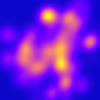

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import geopandas as gpd
import folium

# Define a function to add the KDE heatmap with a color map
def add_kde_heatmap(map_obj, x, y, cmap='viridis'):
    # Perform KDE calculation
    kde = gaussian_kde(np.vstack([x, y]))

    # Define grid for KDE
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    xgrid = np.linspace(xmin, xmax, 100)
    ygrid = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
    Z = Z.reshape(X.shape)
    
    # Normalize Z to 0-1 for color mapping
    Z = (Z - Z.min()) / (Z.max() - Z.min())
    
    # Apply colormap
    colormap = plt.get_cmap(cmap)
    Z_colored = colormap(Z)

    # Convert RGBA to RGB for folium
    Z_colored_rgb = Z_colored[:, :, :3] * 255  # Drop alpha channel and scale to 0-255

    # Create a new ImageOverlay for the heatmap
    folium.raster_layers.ImageOverlay(
        image=Z_colored_rgb.astype('uint8'),
        bounds=[[ymin, xmin], [ymax, xmax]],
        opacity=0.75,
    ).add_to(map_obj)

# Assuming 'buffered_labels' is the GeoDataFrame you are working with
labels_wgs84 = buffered_labels.to_crs(epsg=4326)

# Extract coordinates from GeoDataFrame
x = labels_wgs84.geometry.x
y = labels_wgs84.geometry.y

# Create Folium map
m = folium.Map(location=[np.mean(y), np.mean(x)], zoom_start=16)

# Add KDE heatmap with the specified colormap
add_kde_heatmap(m, x, y, cmap='plasma')  # You can use any Matplotlib colormap here

# Display the map
m



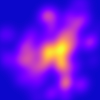

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import geopandas as gpd
import folium

# Define a function to add the KDE heatmap with a color map
def add_weighted_kde_heatmap(map_obj, x, y, weights, cmap='viridis'):
    # Replace NaN values in weights with 0
    weights[np.isnan(weights)] = 0

    # Perform weighted KDE calculation
    kde = gaussian_kde(np.vstack([x, y]), weights=weights)

    # Define grid for KDE
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    xgrid = np.linspace(xmin, xmax, 100)
    ygrid = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
    Z = Z.reshape(X.shape)
    
    # Normalize Z to 0-1 for color mapping
    Z = (Z - Z.min()) / (Z.max() - Z.min())
    
    # Apply colormap
    colormap = plt.get_cmap(cmap)
    Z_colored = colormap(Z)

    # Convert RGBA to RGB for folium
    Z_colored_rgb = Z_colored[:, :, :3] * 255  # Drop alpha channel and scale to 0-255

    # Create a new ImageOverlay for the heatmap
    folium.raster_layers.ImageOverlay(
        image=Z_colored_rgb.astype('uint8'),
        bounds=[[ymin, xmin], [ymax, xmax]],
        opacity=0.75,
    ).add_to(map_obj)

# Assuming 'buffered_labels' is the GeoDataFrame you are working with
labels_wgs84 = buffered_labels.to_crs(epsg=4326)

# Extract coordinates and weights from GeoDataFrame
x = labels_wgs84.geometry.x
y = labels_wgs84.geometry.y
weights = labels_wgs84['severity'].values

# Create Folium map
m = folium.Map(location=[np.mean(y), np.mean(x)], zoom_start=16)

# Add weighted KDE heatmap with the specified colormap
add_weighted_kde_heatmap(m, x, y, weights, cmap='plasma')  # You can use any Matplotlib colormap here

# Display the map
m


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import geopandas as gpd
import folium
import rasterio
from rasterio.transform import from_bounds

# Define a function to add the KDE heatmap with a color map
def add_weighted_kde_heatmap(map_obj, x, y, weights, cmap='viridis'):
    # Replace NaN values in weights with 0
    weights[np.isnan(weights)] = 0

    # Perform weighted KDE calculation
    kde = gaussian_kde(np.vstack([x, y]), weights=weights)

    # Define grid for KDE
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    xgrid = np.linspace(xmin, xmax, 100)
    ygrid = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
    Z = Z.reshape(X.shape)
    
    # Normalize Z to 0-1 for color mapping
    Z = (Z - Z.min()) / (Z.max() - Z.min())
    
    # Apply colormap
    colormap = plt.get_cmap(cmap)
    Z_colored = colormap(Z)

    # Convert RGBA to RGB for folium
    Z_colored_rgb = Z_colored[:, :, :3] * 255  # Drop alpha channel and scale to 0-255

    # Create a new ImageOverlay for the heatmap
    folium.raster_layers.ImageOverlay(
        image=Z_colored_rgb.astype('uint8'),
        bounds=[[ymin, xmin], [ymax, xmax]],
        opacity=0.75,
    ).add_to(map_obj)

    return Z, xmin, xmax, ymin, ymax

# Assuming 'buffered_labels' is the GeoDataFrame you are working with
labels_wgs84 = buffered_labels.to_crs(epsg=4326)

# Extract coordinates and weights from GeoDataFrame
x = labels_wgs84.geometry.x
y = labels_wgs84.geometry.y
weights = labels_wgs84['severity'].values

# Create Folium map
m = folium.Map(location=[np.mean(y), np.mean(x)], zoom_start=16)

# Add weighted KDE heatmap with the specified colormap and get the KDE result
Z, xmin, xmax, ymin, ymax = add_weighted_kde_heatmap(m, x, y, weights, cmap='plasma')  # You can use any Matplotlib colormap here

# Display the map
m

# Save KDE to GeoTIFF
transform = from_bounds(xmin, ymin, xmax, ymax, Z.shape[1], Z.shape[0])
with rasterio.open(
    'kde_weighted_result.tiff', 'w', driver='GTiff', height=Z.shape[0], width=Z.shape[1],
    count=1, dtype=Z.dtype, crs='EPSG:4326', transform=transform
) as dst:
    dst.write(Z, 1)

print("KDE result saved as 'kde_result.tiff'")


KDE result saved as 'kde_result.tiff'


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import geopandas as gpd
import folium
import rasterio
from rasterio.transform import from_bounds

# Define a function to add the KDE heatmap with a color map
def add_weighted_kde_heatmap(map_obj, x, y, cmap='viridis'):
    # Perform weighted KDE calculation
    kde = gaussian_kde(np.vstack([x, y]))

    # Define grid for KDE
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    xgrid = np.linspace(xmin, xmax, 100)
    ygrid = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
    Z = Z.reshape(X.shape)
    
    # Normalize Z to 0-1 for color mapping
    Z = (Z - Z.min()) / (Z.max() - Z.min())
    
    # Apply colormap
    colormap = plt.get_cmap(cmap)
    Z_colored = colormap(Z)

    # Convert RGBA to RGB for folium
    Z_colored_rgb = Z_colored[:, :, :3] * 255  # Drop alpha channel and scale to 0-255

    # Create a new ImageOverlay for the heatmap
    folium.raster_layers.ImageOverlay(
        image=Z_colored_rgb.astype('uint8'),
        bounds=[[ymin, xmin], [ymax, xmax]],
        opacity=0.75,
    ).add_to(map_obj)

    return Z, xmin, xmax, ymin, ymax

# Assuming 'buffered_labels' is the GeoDataFrame you are working with
labels_wgs84 = buffered_labels.to_crs(epsg=4326)

# Extract coordinates and weights from GeoDataFrame
x = labels_wgs84.geometry.x
y = labels_wgs84.geometry.y

# Create Folium map
m = folium.Map(location=[np.mean(y), np.mean(x)], zoom_start=16)

# Add weighted KDE heatmap with the specified colormap and get the KDE result
Z, xmin, xmax, ymin, ymax = add_weighted_kde_heatmap(m, x, y, cmap='plasma')  # You can use any Matplotlib colormap here

# Display the map
m

# Save KDE to GeoTIFF
transform = from_bounds(xmin, ymin, xmax, ymax, Z.shape[1], Z.shape[0])
with rasterio.open(
    'kde_result.tiff', 'w', driver='GTiff', height=Z.shape[0], width=Z.shape[1],
    count=1, dtype=Z.dtype, crs='EPSG:4326', transform=transform
) as dst:
    dst.write(Z, 1)

print("KDE result saved as 'kde_result.tiff'")


KDE result saved as 'kde_result.tiff'
